### Predicting the Price of Homes in Boston

The data are available to load from Scikit-Learn, and you can read more about it [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset).

---
##### Columns in the data set:
- `CRIM`: per capita crime rate by town
- `ZN`: proportion of residential land zoned for lots over 25,000 sq.ft.
- `INDUS`: proportion of non-retail business acres per town
- `CHAS`: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- `NX`: nitric oxides concentration (parts per 10 million)
- `RM`: average number of rooms per dwelling
- `AGE`: proportion of owner-occupied units built prior to 1940
- `DIS`: weighted distances to five Boston employment centres
- `RAD`: index of accessibility to radial highways
- `TAX`: full-value property-tax rate per $10,000
- `PTRATIO`: pupil-teacher ratio by town
- `B`: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

- `LSTAT`: percent lower status of the population
- `MEDV`: Median value of owner-occupied homes in $1000’s

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
%matplotlib inline 


In [4]:
# Read the CSV file into a DataFrame
df = pd.read_csv('datasets/boston.csv')

# Explore the dataframe
df.head()

,CRIM,ZN,INDUS,CHAS,NX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


#### Exploratory Data Analysis
MEDV is the median value of owner-occupied homes in $1000’s (this is back in the 1970s, mind you). Given that I'll explore how well the features we have are correlated with median home prices.

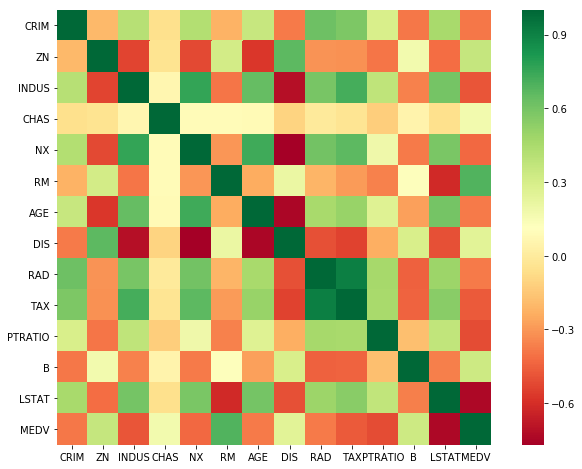

In [55]:
# Plot the correlation between different features in the datatset.
plt.figure(figsize=(11, 8))
sns.heatmap(
    df.corr(), 
    square=True, 
    cmap='RdYlGn')

#### Plotting Features
You can see from the heat map above that`MEDV` is more (positively) correlated with `RM` (average number of rooms) than any other of the features available. Similarly there appears to be several features, like `CRIM` (per capita crime rate), which are negatively correlated with `MEDV`. Let take a closer look at `MEDV` versus `RM` and `CRIM` respectively.

In [51]:
# Create arrays for the feature and target variables
y = df['MEDV'].values
X = df.drop('MEDV', axis=1).values

# Slice an array which contains only the RM column
X_rooms = X[:,5]

# Reshape both y and X_rooms--keep the first dimension and add an additional dimension of size 1 to X_rooms
y = y.reshape(-1,1)
X_rooms = X_rooms.reshape(-1,1)

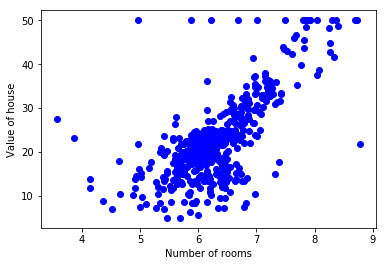

In [52]:
# Plot home price vs number of rooms
plt.scatter(X_rooms, y, color='blue')
plt.ylabel('Value of house')
plt.xlabel('Number of rooms')
plt.show()

#### More Rooms Means Higher Prices
Generally speaking we can see that home prices increase with additional rooms. Just eyeballing the scatter plot one could imagine a line with a positive slope and a certain y-intercept would probably estimate the correlation between home prices and the number of rooms. 

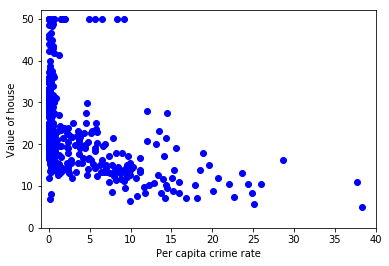

In [53]:
# Slice an array which contains only the CRIM column
X_crim = X[:,0]

# Reshape both X_crim (y was reshaped previously)
X_rooms = X_rooms.reshape(-1,1)

# Plot home price vs number of rooms
plt.scatter(X_crim, y, color='blue')
plt.axis([-1, 40, 0, 52])
plt.ylabel('Value of house')
plt.xlabel('Per capita crime rate')
plt.show()

#### More Crime Means Lower Home Prices
And now we can clearly see the negative correlation which exists between crime rates and median home prices. Similar to the last plot, one could imagine a line with a negative slope and a certain y-intercept which could estimate the correlation between median home prices and the per capita crime rate. However, in both cases a degree of error will be observed given the range of values that deviate from that line.

To get a better sense for what I'm getting at I'll build a model based a single feature, `RM`, fit it to the data, and then plot resulting line on top of the scatter plot. 

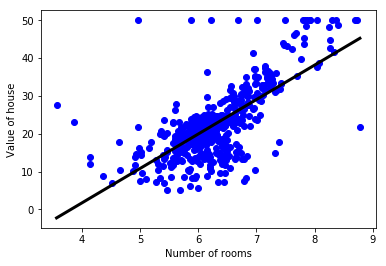

In [57]:
# Instantiate a linear regressor model
reg = LinearRegression()

# Fit the model to the data
reg.fit(X_rooms, y)

# Create the prediction space
prediction_space = np.linspace(min(X_rooms), 
                               max(X_rooms)).reshape(-1,1)

# Plot regression line against
plt.scatter(X_rooms, y, color='blue') 
plt.ylabel('Value of house')
plt.xlabel('Number of rooms')

# Plot a regression line against home price vs. number of rooms
plt.plot(prediction_space, reg.predict(prediction_space), color='black', linewidth=3)

# Display the new plot
plt.show()

#### Regression Line
Great! We can clearly see how a line of best fit correlates the numbers of rooms in a house with the price of a home. But we can also see a number of points with some distance away from the line--that's why models are often called estimators. So how well does this single feature model perform?  

In [58]:
# Print R^2 score
print(reg.score(X_rooms, y))

0.4835254559913343


#### R-squared
One way of measuring a linear model's performance is with R-squared, which is the proportion of the variance in the dependent variable that is predictable from the independent variable (between 0 and 1). Wow, okay, `0.483` is not a great R-squared score, however, we're only using one feature. Will adding more features improve our model?

#### Pre-processing
Before we can fit a robust model to our data we first have to discover if any of our features correlate with one another. We do this to avoid mulitcollinearity, which is the phenomena of independent variable in a regression model being correlated. Our independent variable should be just that, independent. If the degree of correlation between two independent variables is high enough, it can cause problems when you fit the model and try to interpret the results.

In [61]:
# Create a dataframe that doesn't contain the target variable, MEDV
features = df.drop("MEDV", axis=1)

# Create a correlation object of features
corr = features.corr()

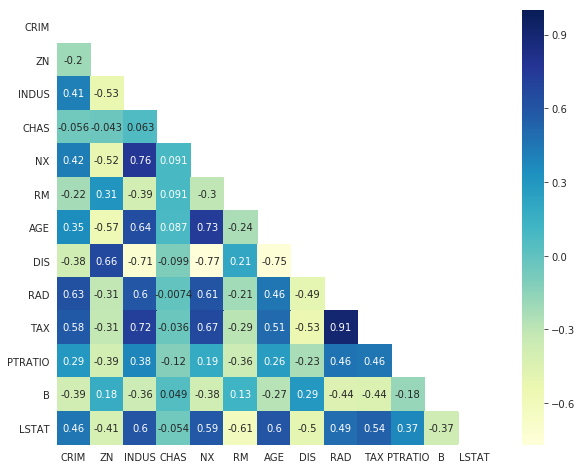

In [62]:
# Plot the feature correlations object
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(11, 8));
    
    sns.heatmap(
        corr,
        ax=ax,
        annot=True,
        mask=mask,
        square=True,
        cmap='YlGnBu')

#### Correlated Independent Features
What stands out like like sore thumb here his the high corrleation between `TAX` and `RAD` (the full-value property-tax rate per $10,000 and index of accessibility to radial highways respectively). In order to fit a regression model to this data we'll have to leave one of these features out. Given we already know that `TAX` is more negatively correlated with `MEDV` I'll be leaving out `RAD`.


In [66]:
# Remove RAD
reduced_features = [f for f in features if f != 'RAD']

#### Ordinary Least Square
The effort following is to establish a base line working model from which we can evalutate feature performance. Later, I'll fine tune a more robust model to make more accurate predictions.

#### Training data and testing data
An effective model is one which performs well on unseen data. As such I'll need to split the data up into a training set and test set. That is to say, we want to train our data to perform well, and then test how well it performs on data it hasn't seen yet.

In [69]:
# Create arrays for features and target variable and transform MEDV values with np.log
y = np.log(df['MEDV'].values)
X = df[reduced_features].values

# Create train and test sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# add constant
X_trainc = sm.add_constant(X_train)

# initialize model
reg = sm.OLS(y_train, X_trainc)

# fit model
fit = reg.fit()

# model summary
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     114.3
Date:                Tue, 20 Nov 2018   Prob (F-statistic):          9.98e-120
Time:                        16:28:17   Log-Likelihood:                 95.142
No. Observations:                 404   AIC:                            -164.3
Df Residuals:                     391   BIC:                            -112.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8200      0.222     17.207      0.000       3.383       4.256
x1            -0.0082      0.001     -6.066      0.000      -0.011      -0.006
x2             0.0005      0.001      0.862      0.389      -0.001       0.002
x3            -0.0022      0.003     -0.774      0.439      -0.008       0.003
x4             0.1405      0.040      3.491      0.001       0.061       0.220
x5            -0.6030      0.172     -3.504      0.001      -0.941      -0.265
x6             0.1062      0.019      5.635      0.000       0.069       0.143
x7           1.04e-05      0.001      0.018      0.986      -0.001       0.001
x8            -0.0462      0.009     -5.187      0.000      -0.064      -0.029
x9         -3.298e-05      0.000     -0.307      0.759      -0.000       0.000
x10           -0.0322      0.006     -5.354      0.000      -0.044      -0.020
x11            0.0002      0.000      1.647      0.100   -4.08e-05       0.000
x12           -0.0292      0.002    -12.648      0.000      -0.034      -0.025
==============================================================================
Omnibus:                       54.281   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              193.988
Skew:                           0.547   Prob(JB):                     7.52e-43
Kurtosis:                       6.214   Cond. No.                     1.45e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### P-value Allows for Further Feature Reduction (P>|t|)
Importantly, x2, x3, x7, and x9 all have P-values which are too high, wich suggests they are not significant predictors of `MEDV`. I'll remove them re-run the model, and see if there any additional features with high P-values.

In [71]:
# Remove x2, x3, x7, and x9
reduced_features = [f for f in features if f not in ['ZN', 'INDUS', 'AGE', 'INDUS', 'RAD']]

# Do it all over again 
y = np.log(df['MEDV'].values)
X = df[reduced_features].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_trainc = sm.add_constant(X_train)
reg = sm.OLS(y_train, X_trainc)
fit = reg.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     172.9
Date:                Tue, 20 Nov 2018   Prob (F-statistic):          6.47e-131
Time:                        16:37:10   Log-Likelihood:                 110.75
No. Observations:                 404   AIC:                            -201.5
Df Residuals:                     394   BIC:                            -161.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3873      0.227     14.891      0.000       2.940       3.834
x1            -0.0066      0.001     -4.686      0.000      -0.009      -0.004
x2             0.1068      0.037      2.875      0.004       0.034       0.180
x3            -0.5824      0.157     -3.706      0.000      -0.891      -0.273
x4             0.1468      0.019      7.909      0.000       0.110       0.183
x5            -0.0420      0.007     -5.803      0.000      -0.056      -0.028
x6         -6.131e-05   9.19e-05     -0.667      0.505      -0.000       0.000
x7            -0.0329      0.005     -6.198      0.000      -0.043      -0.022
x8             0.0005      0.000      4.642      0.000       0.000       0.001
x9            -0.0268      0.002    -12.727      0.000      -0.031      -0.023
==============================================================================
Omnibus:                       66.276   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              347.624
Skew:                           0.558   Prob(JB):                     3.27e-76
Kurtosis:                       7.405   Cond. No.                     1.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### P-value Allows for Further Feature Reduction (P>|t|)
x6 with a P-value of 0.505 is too high, so I'll remove that feature as well.

In [76]:
# Remove x6
reduced_features = [f for f in reduced_features if f != 'TAX']

print(reduced_features)

['CRIM', 'CHAS', 'NX', 'RM', 'DIS', 'PTRATIO', 'B', 'LSTAT']


#### Plotting the Model
What we're left with are only the most predictive feature for which we can build a robust model. A plot of a linear regressor with only these features follows.

Text(0.5,1,'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

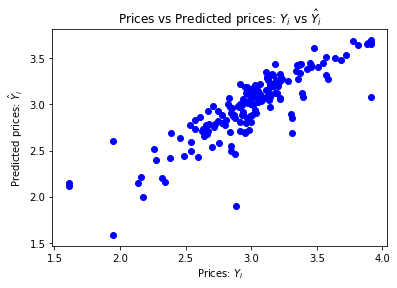

In [77]:
y = np.log(df['MEDV'].values)
X = df[reduced_features].values

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

plt.scatter(y_test, y_pred, color='blue')
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

#### Visualizing the Model
Ideally, the scatter plot should create a more perfect straight line. 

In [78]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

Root Mean Squared Error: 0.19866295466


#### Mean Squared Error
To check the level of error of a model, we can Mean Squared Error. It is one of the procedure to measures the average of the squares of error. Basically, it will check the difference between actual value and the predicted value. For the full theory, you can always search it online. To use it, we can use the mean squared error function of scikit-learn by running this snippet of code.

In [90]:
# Instantiate a ridge regressor
ridge = Ridge(alpha=0.5, normalize=True)

# Perform 5-fold cross-validation
ridge_cv = cross_val_score(ridge, X, y, cv=5)

# Print the cross-validated scores
print(ridge_cv)

[0.73853776 0.77917984 0.50681253 0.48396878 0.48812629]
0.5993250390686805


In [80]:
# Import the neccessary modules
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate an ElasticNet regressor
elastic_net = ElasticNet(tol=1)

# Setup the GridSearchCV object
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.06896551724137931}
Tuned ElasticNet R squared: 0.657763259858
Tuned ElasticNet MSE: 0.0532872715243


In [81]:
# Import the neccessary modules
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps and take the mean of a given feature/column in place of any missing values.
steps = [('imputation', Imputer(missing_values='NaN', strategy='mean', axis=0)),
         ('scaler', StandardScaler()),
         ('elasticnet', ElasticNet(tol=1))]

# Create the pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}

# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline, parameters, cv=5)

# Fit to the training set
gm_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet Alpha: {'elasticnet__l1_ratio': 0.0}
Tuned ElasticNet R squared: 0.683085588391
Tuned ElasticNet MSE: 0.0532872715243


#### Conclusion

I'd hesitate to use this in the real world, seeing as the range of predictions for a single data point covers nearly a standard deviation of the data set it was trained on. Though 'MDEV' was scaled for inflation, that does not account for changes in housing demand within the city since the 1970s, and outside urban areas, features like teacher/student ratio may not correlate with selling price in the same way. We might also be concerned that this model is too simple to capture other indicators of selling price, like school proximity, condition of the house, or crime rate. In summary, with a few tweaks, the model could be adapted to modern Boston, but would be near useless anywhere else.